In [46]:
import torchvision
from torchvision import models
from torchvision.transforms import transforms
from tqdm import tqdm
import torch
import ImageData
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import time
import random

In [17]:
model_name = "resnet_finetune"
model_image_size = 224
random.seed(42)

# vit = models.vit_l_16(models.ViT_L_16_Weights.IMAGENET1K_V1)

In [18]:
class ResNet(torch.nn.Module):
    def __init__(self, numClasses: int, softmax:bool = True):
        super(ResNet, self).__init__()

        self.resnet = torchvision.models.resnet152(weights='DEFAULT')
        for param in list(self.resnet.parameters())[:-1]:
            param.requires_grad = True

        self.resnet.fc = torch.nn.Sequential(
            torch.nn.Linear(2048, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 216),
            torch.nn.ReLU(),
            torch.nn.Linear(216, 4)
        )
        
        
        # for param in self.inceptionBase.parameters():
        #     print(param.requires_grad)

        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, x):
        out = self.resnet(x)
        return out

In [19]:
model = ResNet(4).to(device)
# print(*list(model.children())[:-1])

In [20]:
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [48]:
batch_size = 16
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.RandomResizedCrop(size=(model_image_size, model_image_size), antialias=True), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainDataLoader, validDataLoader, testDataLoader, unseenDataLoader = ImageData.getImagesDataloaders("./ArtiFact/", transforms = transform, batchSize=batch_size)

In [22]:
def evaluate_on_data(model, dataloader, dirty: bool = False):
    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        total_loss = 0
        
        num_correct = 0.0
        num_correct_dirty = 0.0

        num_samples = 0.0
        for data in tqdm(dataloader, desc="Eval: "):
            image, label = data
            label = label.to(device)
            image = image.to(device)
            outputs = model(image)
            
            dirtyLabel = torch.where(label > 1, torch.tensor(1, dtype = torch.int32).to(device), label)

            
            
            loss = criterion(outputs, label)
            total_loss += loss.item()
            argMax = torch.argmax(outputs, 1)

            # print("pred")
            # print(outputs)
            # print(argMax)
            # print("gt")
            # print(label)
            for i in range(len(label)):
                
                if label[i] == argMax[i]:
                    num_correct += 1

                if (dirtyLabel[i] == argMax[i]) or (dirtyLabel[i] == 1 and argMax[i] > 0):
                    num_correct_dirty += 1

                num_samples += 1
                    
                
                
    return total_loss / len(dataloader), num_correct / num_samples, num_correct_dirty / num_samples

In [23]:
num_epochs = 10
count = 0
valid_loss_array = np.zeros(num_epochs)
valid_acc_array = np.zeros(num_epochs)
valid_acc_dirty_array = np.zeros(num_epochs)

train_loss_array = np.zeros(num_epochs)
for epoch in range(num_epochs):
    batch_count = 0
    for data in tqdm(trainDataLoader, desc="Training: "):
        
        image, label = data
        
        label = label.to(device)
        image = image.to(device)

        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
          
        count += 1
        # print(loss)
            
        
    valid_loss, valid_acc, valid_acc_dirty = evaluate_on_data(model, validDataLoader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Valid Loss: {valid_loss}, Valid ACC: {valid_acc}, Dirty Valid ACC: {valid_acc_dirty}')
    valid_loss_array[epoch] = valid_loss
    train_loss_array[epoch] = loss.item()
    valid_acc_array[epoch] = valid_acc
    valid_acc_dirty_array[epoch] = valid_acc_dirty


Eval: 100%|██████████| 6115/6115 [07:12<00:00, 14.15it/s]


Epoch [1/10], Training Loss: 0.4805, Valid Loss: 0.2879639990320117, Valid ACC: 0.8948767224107618, Dirty Valid ACC: 0.9196855705932862


Eval: 100%|██████████| 6115/6115 [06:51<00:00, 14.85it/s]


Epoch [2/10], Training Loss: 0.1069, Valid Loss: 0.24108612333361185, Valid ACC: 0.9120701639612381, Dirty Valid ACC: 0.9336692971337449


Eval: 100%|██████████| 6115/6115 [06:06<00:00, 16.70it/s]


Epoch [3/10], Training Loss: 0.4639, Valid Loss: 0.22677304220289898, Valid ACC: 0.9182033773561762, Dirty Valid ACC: 0.9377069959520792


Eval: 100%|██████████| 6115/6115 [06:01<00:00, 16.91it/s]


Epoch [4/10], Training Loss: 0.0851, Valid Loss: 0.20310916094529577, Valid ACC: 0.9256654536533507, Dirty Valid ACC: 0.9443819765302367


Eval: 100%|██████████| 6115/6115 [06:03<00:00, 16.84it/s]


Epoch [5/10], Training Loss: 0.1104, Valid Loss: 0.18767235382985117, Valid ACC: 0.9321257717626855, Dirty Valid ACC: 0.949799648362432


Eval: 100%|██████████| 6115/6115 [05:55<00:00, 17.18it/s]


Epoch [6/10], Training Loss: 0.0347, Valid Loss: 0.18998438187664296, Valid ACC: 0.931287565932044, Dirty Valid ACC: 0.9479699063662755


Eval: 100%|██████████| 6115/6115 [05:59<00:00, 16.99it/s]


Epoch [7/10], Training Loss: 0.1192, Valid Loss: 0.1781213577413735, Valid ACC: 0.9352945986834035, Dirty Valid ACC: 0.9521098254078587


Eval: 100%|██████████| 6115/6115 [05:56<00:00, 17.17it/s]


Epoch [8/10], Training Loss: 0.0391, Valid Loss: 0.16991417511480153, Valid ACC: 0.9394651837919614, Dirty Valid ACC: 0.954154229872838


Eval: 100%|██████████| 6115/6115 [05:56<00:00, 17.16it/s] 


Epoch [9/10], Training Loss: 0.0538, Valid Loss: 0.1758850871313309, Valid ACC: 0.9365519074293658, Dirty Valid ACC: 0.9530911395510487


Eval: 100%|██████████| 6115/6115 [05:53<00:00, 17.32it/s]

Epoch [10/10], Training Loss: 0.8865, Valid Loss: 0.16627700620591496, Valid ACC: 0.940599828270025, Dirty Valid ACC: 0.9567506235433618


In [24]:
with open(model_name + '_valid_loss.npy', 'wb') as f:
    np.save(f, valid_loss_array)
    
with open(model_name + '_valid_acc.npy', 'wb') as f:
    np.save(f, valid_acc_array)

with open(model_name + '_valid_dirty_acc.npy', 'wb') as f:
    np.save(f, valid_acc_dirty_array)
    
with open(model_name + '_train.npy', 'wb') as f:
    np.save(f, train_loss_array)

In [25]:
import matplotlib.pyplot as plt

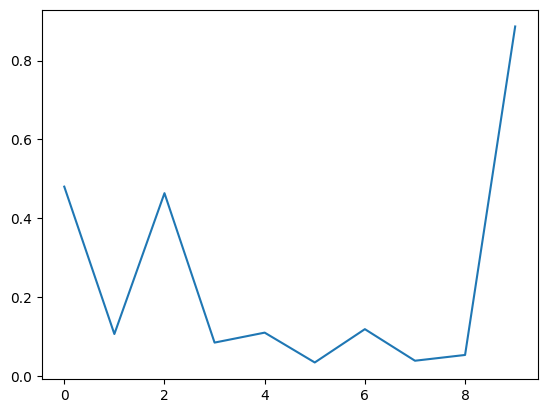

In [26]:
plt.plot(train_loss_array)

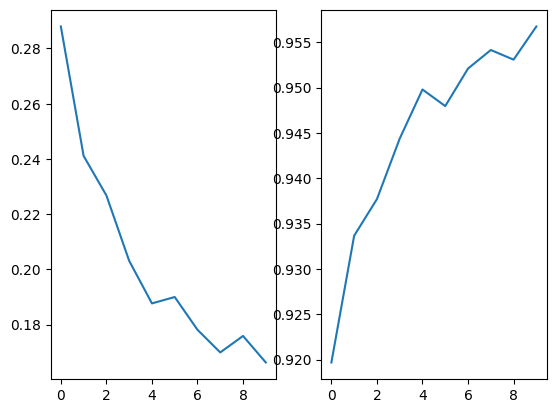

In [27]:
figure, axis = plt.subplots(1,2)
axis[0].plot(valid_loss_array)
axis[1].plot(valid_acc_dirty_array)

In [28]:
test_loss, test_acc, test_acc_dirty = evaluate_on_data(model, testDataLoader, dirty=True)
print(f'Test Loss: {test_loss}, Test ACC: {test_acc}, Dirty Test ACC: {test_acc_dirty}')

Eval: 100%|██████████| 33761/33761 [45:18<00:00, 12.42it/s] 

Test Loss: 0.31110995044763984, Test ACC: 0.900583517842465, Dirty Test ACC: 0.9251238494405486


In [32]:
torch.save(model.state_dict(), "finetuneResnet.pth")

In [49]:
unseen_loss, unseen_acc, unseen_acc_dirty = evaluate_on_data(model, unseenDataLoader, dirty=True)
print(f'Unseen Loss: {unseen_loss}, Unseen ACC: {unseen_acc}, Dirty Unseen ACC: {unseen_acc_dirty}')

Eval: 100%|██████████| 1569/1569 [01:18<00:00, 19.94it/s]

Unseen Loss: 1.299870536880481, Unseen ACC: 0.5722425884603124, Dirty Unseen ACC: 0.7784109021357986
